In [1]:
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate
# Tested with transformers==4.46.3, trl==0.12.2, datasets==3.2.0, bitsandbytes==0.45.0, peft==0.14.0, accelerate==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.5/511.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [2]:
!pip install -q flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [14]:
from datasets import load_dataset

dataset_id = "HuggingFaceH4/rlaif-v_formatted"
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:1%]', 'test[:1%]'])

In [15]:
from PIL import Image

def ensure_rgb(example):
    # Convert the image to RGB if it's not already
    image = example['images'][0]
    if isinstance(image, Image.Image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        example['images'] = [image]
    return example

# Apply the transformation to the dataset
train_dataset = train_dataset.map(ensure_rgb, num_proc=32)
test_dataset = test_dataset.map(ensure_rgb, num_proc=32)

Map (num_proc=32):   0%|          | 0/790 [00:00<?, ? examples/s]

In [16]:
train_dataset[20]

{'chosen': [{'content': [{'text': "Yes, the grass in the image appears to be brown. This could indicate that the photo was taken during a dry season or in a region that experiences arid conditions. The brown grass contrasts with the grayish color of the elephant and provides a natural background that highlights the elephant's presence in its environment.",
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'Yes, the grass in the image appears to be brown. This could be due to a number of reasons such as the season (it might be a dry season), the type of grass, or the specific conditions of the environment where the photo was taken. The brown grass contrasts with the grayish color of the elephant and the white branches of the thorny tree, making it a prominent feature of the landscape.',
     'type': 'text'}],
   'role': 'assistant'}],
 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>],
 'prompt': [{'content': [{'text': None, '

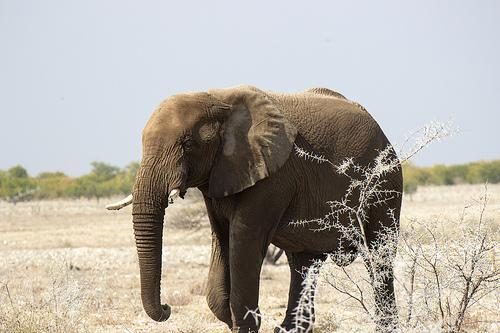

In [17]:
train_dataset[20]['images'][0]

In [8]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

In [9]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [10]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=True,
    init_lora_weights="gaussian"
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


In [11]:
from trl import DPOConfig

training_args = DPOConfig(
    output_dir="smolvlm-instruct-trl-dpo-rlaif-v",
    bf16=True,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=32,
    num_train_epochs=5,
    dataset_num_proc=8,  # tokenization will use 8 processes
    dataloader_num_workers=8,  # data loading will use 8 workers
    logging_steps=10,
    report_to="tensorboard",
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,
    save_total_limit=1,
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",
)

In [21]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    processing_class=processor,
)

Tokenizing train dataset (num_proc=8):   0%|          | 0/790 [00:00<?, ? examples/s]

RuntimeError: One of the subprocesses has abruptly died during map operation.To debug the error, disable multiprocessing.

In [ ]:
trainer.train()

In [ ]:
trainer.save_model(training_args.output_dir)

In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

In [ ]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

In [ ]:
adapter_path = "sergiopaniego/smolvlm-instruct-trl-dpo-rlaif-v"
model.load_adapter(adapter_path)

In [ ]:
test_dataset[20]

In [ ]:
test_dataset[20]['images'][0]

In [ ]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample['prompt'],
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample['images'][0]
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[20])
output